# Reading data

In [3]:
# image processing
import numpy as np
import tifffile as tiff
import matplotlib as mpl
from matplotlib import pyplot as plt
import random
import math
import pickle

#modeling 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,\
                                    concatenate, Conv2DTranspose

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import TensorBoard

mpl.rcParams['figure.figsize'] = (10,10)

In [4]:
data_path = '/home/jliu0604/AML/satelite_image/data'
PATCH_SIZE = 160

In [11]:
# test reading image
img = tiff.imread(data_path + '/gt_mband/01.tif')

In [12]:
#img.shape

In [13]:
#plt.imshow(img[1,:,:])

In [14]:
#tiff.imshow(img[(3,2,1),:,:])

In [15]:
# superimpose mask on to the satelite images
st_img = tiff.imread(data_path + '/mband/01.tif')
mask = tiff.imread(data_path + '/gt_mband/01.tif')


def superimpose_stlite_mask(st_img, mask, color = (10,0,0)):
        #normalize image and select only three channels to display
        st_normed = 255.0 * st_img / st_img.max()
        # create color mask using RGB channles
        colored_mask = np.stack([mask*color[0], mask*color[1], mask*color[2]])
        # combine the colored_mask and st_img together
        combined = (st_normed + colored_mask).clip(0,255).astype(np.uint8)
        return combined

In [16]:
#combined = superimpose_stlite_mask(st_img[(4,2,1),:,:], mask[0,:,:])
#tiff.imshow(combined)

# Normalize the image
Normalize image to make each pixel within the range of [-1,1]

Since we need to compare the input image 𝐼 to the output image 𝐼ˆ, it should be readily possible to enforce the pixel values of 𝐼ˆ into a simple, known, hard range. Using sigmoid produces values in [0,1], while using tanh does so in [−1,1]. However, it is often thought that that tanh is better than sigmoid; e.g.,

https://stats.stackexchange.com/questions/142348/tanh-vs-sigmoid-in-neural-net

https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function/369538

https://stats.stackexchange.com/questions/101560/tanh-activation-function-vs-sigmoid-activation-function

In other words, for cases where the output must match the input, using [−1,1] may be a better choice. Furthermore, though not "standardized", the range [−1,1] is still zero-centered (unlike [0,1]), which is easier for the network to learn to standardize (though I suspect this matters only rather early in training). https://datascience.stackexchange.com/questions/54296/should-input-images-be-normalized-to-1-to-1-or-0-to-1

In [17]:
def normalize_images(img):
    normalized = 2 * (img - img.min()) / (img.max() - img.min()) - 1
    return normalized

In [18]:
#st_img.max()

In [19]:
#normalize_images(st_img).max()

In [20]:
#st_img.shape

# Creating extented images
Since it's difficult for CNN to train on the image edges, creating extended edges will help on training. We will fill the extended edges using mirror images. So far, just extended the right and bottom part, but this can be further improved by extend all four edges.

In [21]:
# creat extented x and mask
# def create_extended_imgs(x, mask, PATCH_SIZE = PATCH_SIZE):
#     img_height = x.shape[1]
#     img_width = x.shape[2]
#     n_channels = x.shape[0]
#     n_classes = mask.shape[0]
#     # make extended image with mirror filler
#     npatches_vertical = math.ceil(img_height / PATCH_SIZE)
#     npatches_horizontal = math.ceil(img_width / PATCH_SIZE)
#     ext_x = np.zeros(shape = (n_channels, npatches_vertical*PATCH_SIZE, npatches_horizontal*PATCH_SIZE), dtype = np.float32)
#     ext_m = np.zeros(shape = (n_classes, npatches_vertical*PATCH_SIZE, npatches_horizontal*PATCH_SIZE), dtype = np.float32)
#     #print(ext_x.shape)
#     # fill extended image with mirror filler
#     ext_x[:,:img_height, :img_width] = x
#     ext_m[:,:img_height, :img_width] = mask
#     for i in range(img_height, ext_x.shape[1]):
#         #print(x[:,2*img_height - i -1, :])
#         #can't use ext_x[:,i,:] = x[:,2*img_height - i -1, :], since x, ext_x shape is different
#         ext_x[:,i,:] = ext_x[:,2*img_height - i -1, :]
#         ext_m[:,i,:] = ext_m[:,2*img_height - i -1, :]
#     for i in range(img_width, ext_x.shape[2]):
#         ext_x[:,:,i] = ext_x[:,:,2*img_width -i -1]
#         ext_m[:,:,i] = ext_m[:,:,2*img_width -i -1]

#     return ext_x, ext_m

In [22]:
# creat extented x and mask
def create_extended_imgs(x, mask = None, PATCH_SIZE = PATCH_SIZE):
    img_height = x.shape[1]
    img_width = x.shape[2]
    n_channels = x.shape[0]
  
    # make extended image with mirror filler
    npatches_vertical = math.ceil(img_height / PATCH_SIZE)
    npatches_horizontal = math.ceil(img_width / PATCH_SIZE)
    ext_x = np.zeros(shape = (n_channels, npatches_vertical*PATCH_SIZE, npatches_horizontal*PATCH_SIZE), dtype = np.float32)
  
    #print(ext_x.shape)
    # fill extended image with mirror filler
    ext_x[:,:img_height, :img_width] = x
   
    for i in range(img_height, ext_x.shape[1]):
        #print(x[:,2*img_height - i -1, :])
        #can't use ext_x[:,i,:] = x[:,2*img_height - i -1, :], since x, ext_x shape is different
        ext_x[:,i,:] = ext_x[:,2*img_height - i -1, :]
    for i in range(img_width, ext_x.shape[2]):
        ext_x[:,:,i] = ext_x[:,:,2*img_width -i -1]

    if mask is not None:
        n_classes = mask.shape[0]
        ext_m = np.zeros(shape = (n_classes, npatches_vertical*PATCH_SIZE, npatches_horizontal*PATCH_SIZE), dtype = np.float32)
        ext_m[:,:img_height, :img_width] = mask
        for i in range(img_height, ext_x.shape[1]):
        #print(x[:,2*img_height - i -1, :])
        #can't use ext_x[:,i,:] = x[:,2*img_height - i -1, :], since x, ext_x shape is different
            ext_m[:,i,:] = ext_m[:,2*img_height - i -1, :]
        for i in range(img_width, ext_x.shape[2]):
            ext_m[:,:,i] = ext_m[:,:,2*img_width -i -1]
        return ext_x, ext_m
    
    return ext_x

In [23]:
#filled_img, filled_mask = create_extended_imgs(st_img, mask)

In [24]:
#tiff.imshow(filled_img[(4,2,1),:,:])

In [25]:
#tiff.imshow(filled_mask[(4,2,1),:,:])

# Creating random patches
Our image is 837*851, it's usually too large for the network to train, so we will create patches. However, one concern with creating pathes is we might lose information on cropped image edges, so will creating mirror images for the edges.

Since we can absolutely crop images side by side and creating mirror images on the edges, this might also put us in risk of lossing information on edges. So another way to optimize it is to randomly cropping over an image, that way some of the patches will overlap with each other and get trained.

In [26]:
def get_random_patches(img, mask, PATCH_SIZE = PATCH_SIZE):
    assert len(img.shape) == 3 and img.shape[1] > PATCH_SIZE
    assert img.shape[2] > PATCH_SIZE 
    assert img.shape[1:3] == mask.shape[1:3]
    
    xc = random.randint(0, img.shape[2] - PATCH_SIZE)
    yc = random.randint(0, img.shape[1] - PATCH_SIZE)
    
    new_img = img[:, yc : (yc + PATCH_SIZE), xc: (xc + PATCH_SIZE)]
    new_mask = mask[:, yc : (yc + PATCH_SIZE), xc: (xc + PATCH_SIZE)]
    
    return new_img, new_mask

In [27]:
#patch_img, pathc_mask = get_random_patches(st_img, mask, 160)

In [28]:
#img.shape

In [29]:
#plt.imshow(patch_img[5,:,:])

Now we need to generate random patches for the images

In [30]:
def get_patches(img, mask, n_patches, PATCH_SIZE):
    xs = list()
    ys = list()
    
    total_patches = 0
    while total_patches < n_patches:
        img_patch, mask_patch = get_random_patches(img, mask, PATCH_SIZE)
        xs.append(img_patch)
        ys.append(mask_patch)
        total_patches += 1
    print('generated {} pacthes images'.format(total_patches))
    return np.array(xs), np.array(ys)

In [31]:
#xs, ys = get_patches(st_img,mask,10,160)

In [32]:
# if we have a list of images, put them into dictionary, random sampling from the list
def get_patches_batch(x_dict, y_dict, n_patches, sz=PATCH_SIZE):
    x = list()
    y = list()
    
    n_imgs = len(x_dict)
    # make sure each image will get sampled
    sub_npatches = n_patches // n_imgs
    left_npatches = n_patches % n_imgs
    
    total_patches = 0
    

    for i in list(x_dict.keys()):
        while total_patches < int(i)*sub_npatches:
            img = x_dict[i]
            mask = y_dict[i]

            img_patch, mask_patch = get_random_patches(img, mask, PATCH_SIZE)
            x.append(img_patch)
            y.append(mask_patch)

            total_patches += 1
    # The rest images will be filled from image 01        
    while total_patches < n_patches:
        img_patch, mask_patch = get_random_patches(x_dict['01'], y_dict['01'], PATCH_SIZE)
        x.append(img_patch)
        y.append(mask_patch)

        
        total_patches += 1
    print('Generated {} patches'.format(total_patches))
    return np.array(x), np.array(y)


In [33]:
#x_train,y_train=get_patches_batch(X_DICT_TRAIN,Y_DICT_TRAIN, 100, 160)

In [34]:
#x_train.shape,y_train.shape

In [35]:
# for i in range(1,11):
#     plt.subplot(2,5,i)
#     plt.imshow(xs[i-1][4,:,:])

# Creating predictions
The prediction will also be doing on the extended images, since this will helps on predicting the edges. After that, will crop the extended area. Similarly, this is base on only right and bottom edge mirror extended prediction. Further imporvement can be achieved.

In [36]:
def prediction(img, model, PATCH_SIZE = PATCH_SIZE, n_classes = 5):
    ext_x = create_extended_imgs(img, mask = None)
    img_height = img.shape[1]
    img_width = img.shape[2]
    npatches_vertical = int(ext_x.shape[1] / PATCH_SIZE)
    npatches_horizontal = int(ext_x.shape[2] / PATCH_SIZE)
    
    # assemble all patches into one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i*PATCH_SIZE, (i+1)*PATCH_SIZE
            y0, y1 = j*PATCH_SIZE, (j+1)*PATCH_SIZE
            
            patches_list.append(ext_x[:,y0:y1,x0:x1])
    patches_array = np.asarray(patches_list)
    patches_array = patches_array.transpose([0,2,3,1])
    print(patches_array.shape)
    #return patches_array

# predictions:
    #patches_predict = patches_array[:,:,:,(1,2,3,4,5)]
    #print(patches_predict.shape)
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(ext_x.shape[1], ext_x.shape[2], n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        print(k)
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * PATCH_SIZE, (i + 1) * PATCH_SIZE
        y0, y1 = j * PATCH_SIZE, (j + 1) * PATCH_SIZE
        print(x0,x1,y0,y1)
        prediction[y0:y1, x0:x1, :] = patches_predict[k,:, :, :]
    return prediction[:img_height, :img_width, :]

In [37]:
#5%36

In [38]:
#model = 1
#ptest = prediction(test_image, model)

In [39]:
#filled_img.shape

In [40]:
#ptest.shape

In [41]:
#tiff.imshow(ptest[:,:,(4,2,1)])

In [42]:
#test_image.shape

In [43]:
#tiff.imshow(test_image[4,:,:])

# Create the model

In [44]:
#base model
# def model_unet(n_classes = 5, im_size = PATCH_SIZE, n_channels = 8, n_filters_start =4, growth_factor =2):
#     n_filters = n_filters_start
    
#     # create model using functional API. It is generally recommend to use the functional layer API via Input, (which creates an InputLayer) without directly using InputLayer.
#     inputs = Input((im_size, im_size, n_channels))
#     conv1 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(inputs)
#     pool1 = MaxPooling2D((2,2))(conv1)
#     n_filters *= growth_factor
#     conv2 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(pool1)
    
#     n_filters //= growth_factor
#     upconv = Conv2DTranspose(n_filters, (2,2), strides = (2,2), padding = 'same')(conv2)
#     concat = concatenate([conv1, upconv])
#     conv3 = Conv2D(n_filters, (3,3), activation = 'relu', padding = 'same')(concat)
#     output = Conv2D(n_classes, (1,1), activation = 'sigmoid')(conv3)
#     model = Model(inputs = inputs, outputs = output)
    
#     # compiling model
#     model.compile(optimizer = Adam(), loss = 'binary_crossentropy')
    
#     return model

In [45]:
# deeper model
def model_unet(n_classes = 5, im_size = PATCH_SIZE, n_channels = 8, n_filters_start =8, growth_factor =2):
    n_filters = n_filters_start
    
    # create model using functional API. It is generally recommend to use the functional layer API via Input, (which creates an InputLayer) without directly using InputLayer.
    inputs = Input((im_size, im_size, n_channels))
    n_filters *= growth_factor
    conv1 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(inputs)
    pool1 = MaxPooling2D((2,2))(conv1)
    n_filters *= growth_factor
    conv2 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(pool1)
    pool2 = MaxPooling2D((2,2))(conv2)
    n_filters *= growth_factor
    conv3 = Conv2D(n_filters, (3,3), padding = 'same', activation = 'relu')(pool2)
    pool3 = MaxPooling2D((2,2))(conv3)
    
   
    upconv1 = Conv2DTranspose(n_filters, (2,2), strides = (2,2), padding = 'same')(pool3)
    n_filters //= growth_factor
    concat1 = concatenate([conv3, upconv1])
    conv4 = Conv2D(n_filters, (3,3), activation = 'relu', padding = 'same')(concat1)
    upconv2 = Conv2DTranspose(n_filters, (2,2), strides = (2,2), padding = 'same')(conv4)
    concat2 = concatenate([conv2, upconv2])
    conv5 = Conv2D(n_filters, (3,3), activation = 'relu', padding = 'same')(concat2)
    n_filters //= growth_factor
    upconv3 = Conv2DTranspose(n_filters, (2,2), strides = (2,2), padding = 'same')(conv5)
    concat3 = concatenate([conv1, upconv3])
    conv6 = Conv2D(n_filters, (3,3), activation = 'relu', padding = 'same')(concat3)
    
    output = Conv2D(n_classes, (1,1), activation = 'sigmoid')(conv6)
    model = Model(inputs = inputs, outputs = output)
    
    # compiling model
    model.compile(optimizer = Adam(), loss = 'binary_crossentropy')
    
    return model

In [38]:
model = model_unet()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 16) 1168        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

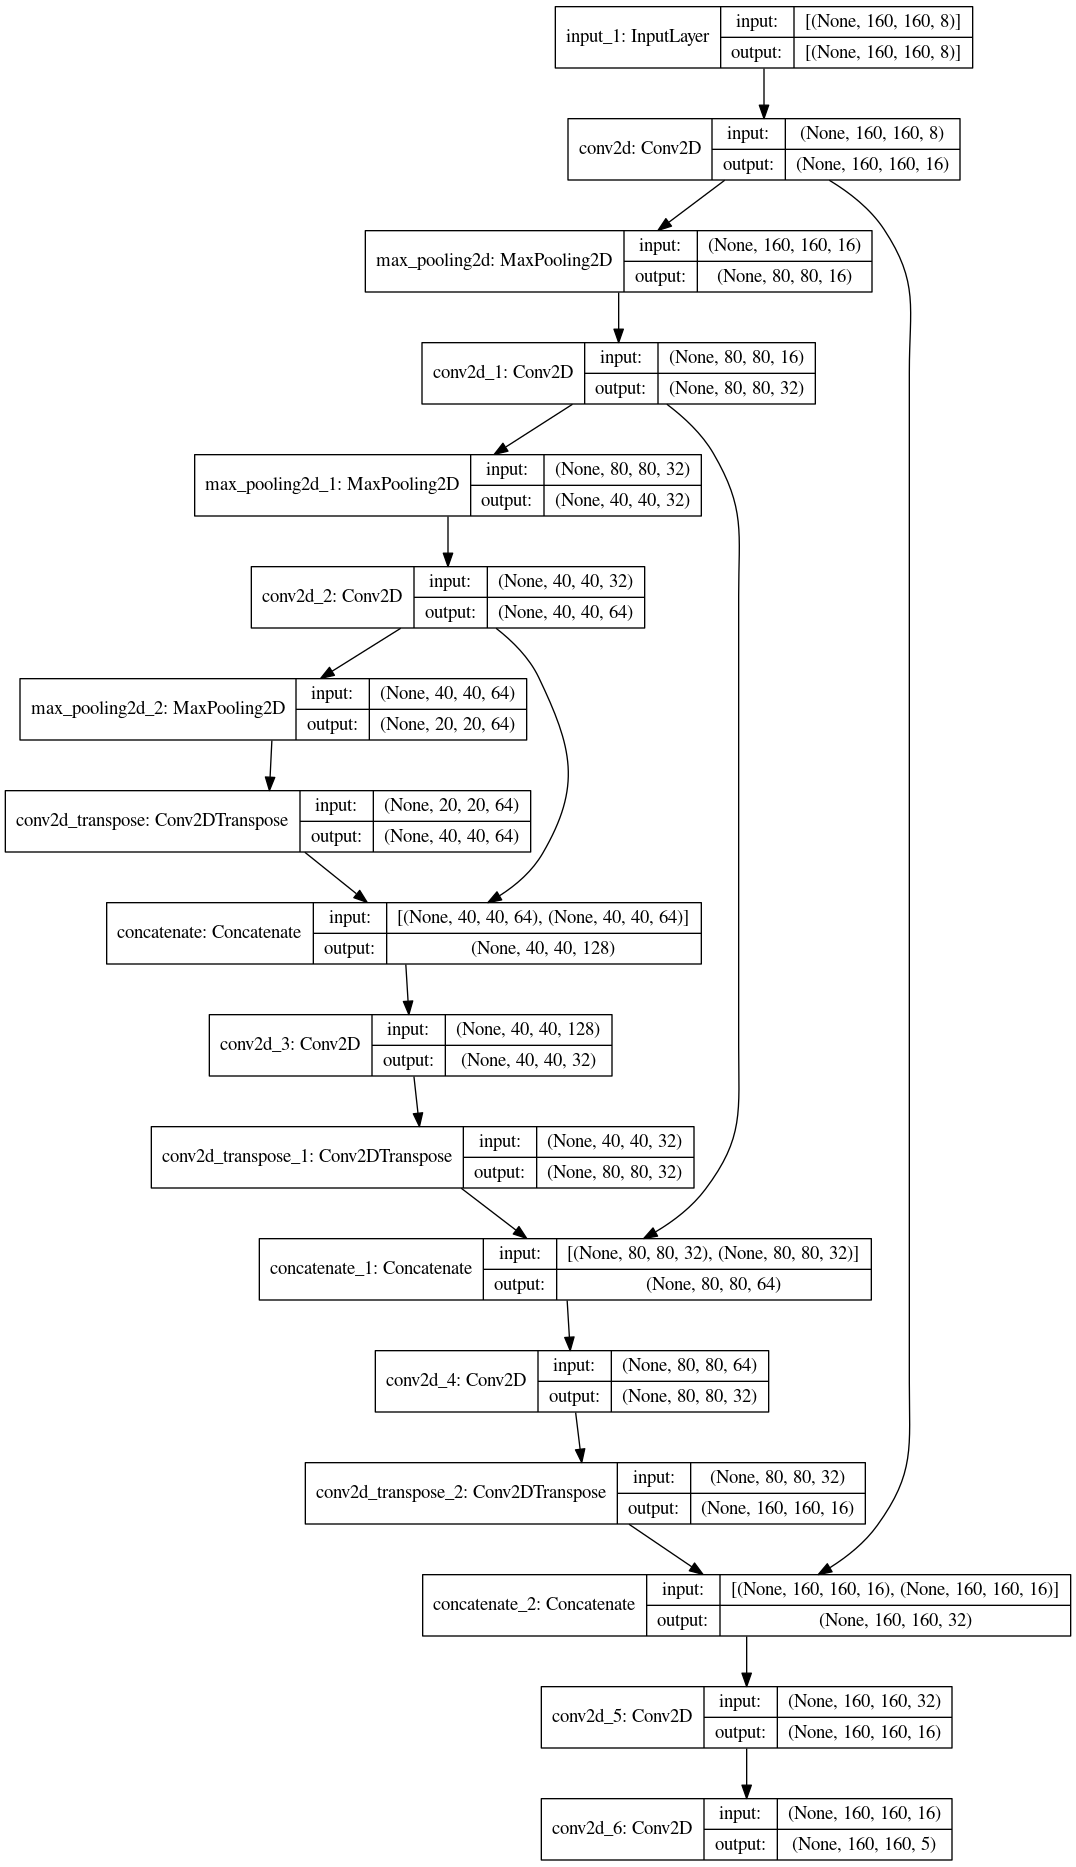

In [40]:
plot_model(model, show_shapes=True)
#plt.imshow(imageio.imread('simple_unet.png'))

# Trainging on model

In [69]:
img_ids = [str(i).zfill(2) for i in range(1, 25)] 

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VALIDATION = dict()
Y_DICT_VALIDATION = dict()

print('Reading images')
for img_id in img_ids:
    img_m = normalize_images(tiff.imread('/home/jliu0604/AML/satelite_image/data/mband/{}.tif'.format(img_id)))
    # use mask to / 255 put it in the range of [0,1], the end result will be multiply wit 255
    mask = tiff.imread('/home/jliu0604/AML/satelite_image/data/gt_mband/{}.tif'.format(img_id)) / 255
    train_xsz = int(3/4 * img_m.shape[1])  # use 75% of image as train and 25% for validation
    X_DICT_TRAIN[img_id] = img_m[:,:train_xsz, :]
    Y_DICT_TRAIN[img_id] = mask[:,:train_xsz, :]
    X_DICT_VALIDATION[img_id] = img_m[:,:train_xsz, :]
    Y_DICT_VALIDATION[img_id] = mask[:,:train_xsz, :]
    print(img_id + ' read')
print('Images were read')

Reading images
01 read
02 read
03 read
04 read
05 read
06 read
07 read
08 read
09 read
10 read
11 read
12 read
13 read
14 read
15 read
16 read
17 read
18 read
19 read
20 read
21 read
22 read
23 read
24 read
Images were read


In [70]:
test_image = normalize_images(tiff.imread('/home/jliu0604/AML/satelite_image/data/mband/test.tif'))

In [71]:
test_image.shape

(8, 848, 837)

In [72]:
#check if the data has been normalized, this is channel first
X_DICT_TRAIN['01'].max(),X_DICT_TRAIN['01'].min() ,X_DICT_TRAIN['01'].shape

(1.0, -1.0, (8, 627, 851))

In [73]:
# get random patches for train, test
TRAINING_TOTAL = 1000
VALIDATION_TOTAL = 50
x_train, y_train = get_patches_batch(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=TRAINING_TOTAL, sz=PATCH_SIZE)
x_val, y_val = get_patches_batch(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VALIDATION_TOTAL, sz=PATCH_SIZE)

Generated 100 patches
Generated 50 patches


In [46]:
#x_train.shape, y_train.shape

In [47]:
#x_val.shape, y_val.shape

# Train the model

In [74]:
# transpose images to make channel last
x_val = x_val.transpose([0,2,3,1])#
x_val.shape
y_val = y_val.transpose([0,2,3,1])
x_train = x_train.transpose([0,2,3,1])
y_train = y_train.transpose([0,2,3,1])

In [80]:
np.save('/home/jliu0604/AML/satelite_image/data/xy_array/x_val.npy', x_val)
np.save('/home/jliu0604/AML/satelite_image/data/xy_array/y_val.npy', y_val)
np.save('/home/jliu0604/AML/satelite_image/data/xy_array/x_train.npy', x_train)
np.save('/home/jliu0604/AML/satelite_image/data/xy_array/y_train.npy', y_train)

In [49]:
#x_train.shape, y_train.shape

In [50]:
#x_val.shape, y_val.shape

In [51]:
# Now training the model:
N_EPOCHS = 10
BATCH_SIZE = 32
# ask Keras to save best weights (in terms of validation loss) into file:
model_checkpoint = ModelCheckpoint(filepath='weights_simple_unet.hdf5', monitor='val_loss', save_best_only=True)
# ask Keras to log each epoch loss:
csv_logger = CSVLogger('log.csv', append=True, separator=';')
# ask Keras to log info in TensorBoard format:
tensorboard = TensorBoard(log_dir='tensorboard_simple_unet_deep_model/', write_graph=True, write_images=True)
# Fit:
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
          verbose=0, shuffle=True,
          callbacks=[model_checkpoint, csv_logger, tensorboard],
          validation_data=(x_val, y_val))

In [52]:
predicted_mask = prediction(test_image, model)

(36, 160, 160, 8)
0
0 160 0 160
1
0 160 160 320
2
0 160 320 480
3
0 160 480 640
4
0 160 640 800
5
0 160 800 960
6
160 320 0 160
7
160 320 160 320
8
160 320 320 480
9
160 320 480 640
10
160 320 640 800
11
160 320 800 960
12
320 480 0 160
13
320 480 160 320
14
320 480 320 480
15
320 480 480 640
16
320 480 640 800
17
320 480 800 960
18
480 640 0 160
19
480 640 160 320
20
480 640 320 480
21
480 640 480 640
22
480 640 640 800
23
480 640 800 960
24
640 800 0 160
25
640 800 160 320
26
640 800 320 480
27
640 800 480 640
28
640 800 640 800
29
640 800 800 960
30
800 960 0 160
31
800 960 160 320
32
800 960 320 480
33
800 960 480 640
34
800 960 640 800
35
800 960 800 960


In [56]:
predicted_mask.shape

(848, 837, 5)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f17d8049d10>)

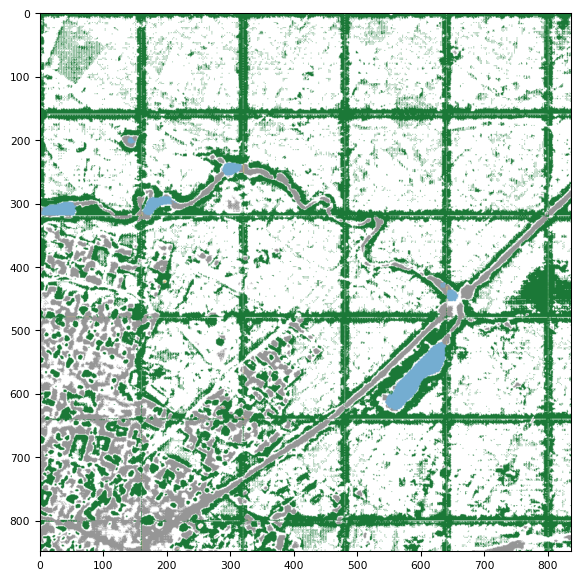

In [51]:
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150],  # Buildings (grey)
        1: [223, 194, 125],  # Roads & Tracks (light orange)
        2: [27, 120, 55],    # Trees (green)
        3: [166, 219, 160],  # Crops (greyish-green)
        4: [116, 173, 209]   # Water (blue)
    }
    z_order = {
        1: 3,
        2: 4,
        3: 0,
        4: 1,
        5: 2
    }
    pict = 255*np.ones(shape=(mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(1, 6):
        cl = z_order[i]
        for ch in range(3):
            pict[:,:,ch][mask[:,:,cl] > threshold] = colors[cl][ch]
    return pict

y_pict = picture_from_mask(predicted_mask, threshold = 0.2)
tiff.imshow(y_pict)

(<Figure size 988.8x604.8 with 2 Axes>,
 <matplotlib.image.AxesImage at 0x7f4818317210>)

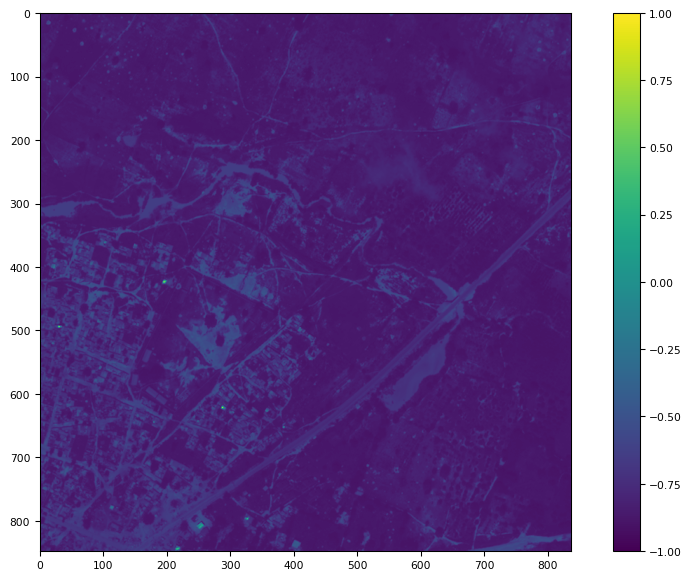

In [63]:
tiff.imshow(test_image[4])

In [11]:
predicted_mask = 1

In [5]:
reconstructed_model = load_model('home/jliu0604/AML/satelite_image/results/more_data/weights_simple_unet_more_data.hdf5')

In [7]:
reconstructed_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 16) 1168        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 32)   4640        max_pooling2d[0][0]              
______________________________________________________________________________________________

# Prediction from test

In [49]:
predicted_mask = prediction(test_image, reconstructed_model)

(36, 160, 160, 8)
0
0 160 0 160
1
0 160 160 320
2
0 160 320 480
3
0 160 480 640
4
0 160 640 800
5
0 160 800 960
6
160 320 0 160
7
160 320 160 320
8
160 320 320 480
9
160 320 480 640
10
160 320 640 800
11
160 320 800 960
12
320 480 0 160
13
320 480 160 320
14
320 480 320 480
15
320 480 480 640
16
320 480 640 800
17
320 480 800 960
18
480 640 0 160
19
480 640 160 320
20
480 640 320 480
21
480 640 480 640
22
480 640 640 800
23
480 640 800 960
24
640 800 0 160
25
640 800 160 320
26
640 800 320 480
27
640 800 480 640
28
640 800 640 800
29
640 800 800 960
30
800 960 0 160
31
800 960 160 320
32
800 960 320 480
33
800 960 480 640
34
800 960 640 800
35
800 960 800 960


(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f179c378850>)

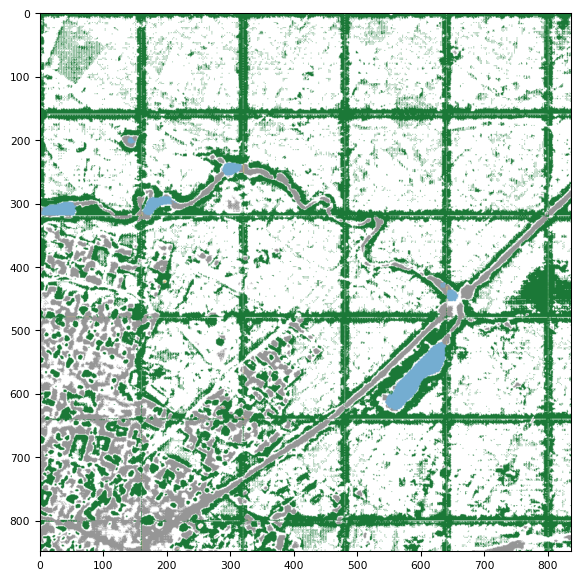

In [57]:
y_pict = picture_from_mask(predicted_mask, threshold = 0.2)
tiff.imshow(y_pict)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f177c5fc3d0>)

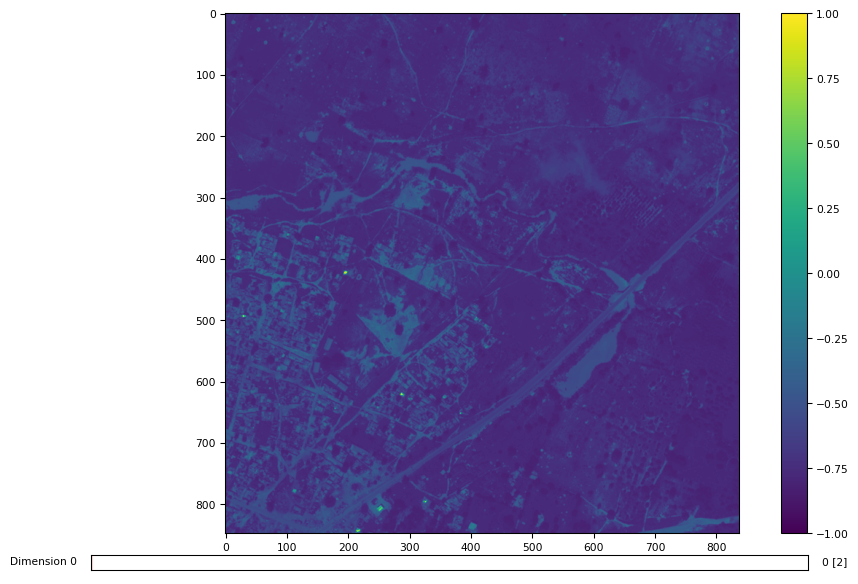

In [65]:
tiff.imshow(test_image[(3,4),:,:])